# Time-Series Forecasting with Traditional Methods  + Facebook’s Prophet

## Introduction

The main focus of this notebook is to be familar with different **Time Series Modeling Techniques**.

This project demonstrates one possible application of time series modeling, which is to to make **price forecasts**.

Here, I will be using historic **Google Stock Price** data and will try to build model(s) in order to make future price prediction of this stock.

Data source: [Yahoo Finance](https://finance.yahoo.com)


### Environment Setup

First we import the required packages to work with and import the stock data.

Here while downloading the stock data, I've created separate **train** and **test** datasets so that it's easy for me to develop model(s) and check prediction accuracy.

In [0]:
#importing required packages
import numpy as np
import pandas as pd
import warnings
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as stm
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

In [0]:
#importing the datasets
train_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Colab Datasets/GoogleStockData/google_train.csv')
test_set = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Colab Datasets/GoogleStockData/google_test.csv')

I put aside the test dataset as it should only be used for model accuracy testing purposes.

Now let's take a look at the training dataset and will try to get a feel about it

In [0]:
train_set.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [0]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
Date         1259 non-null object
Open         1259 non-null float64
High         1259 non-null float64
Low          1259 non-null float64
Close        1259 non-null float64
Adj Close    1259 non-null float64
Volume       1259 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [0]:
train_set.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,652.704082,657.475653,647.433700,652.657015,652.657015,2.414928e+06
std,175.630574,176.627416,174.732814,175.820993,175.820993,1.672160e+06
min,350.053253,350.391052,345.512787,349.164032,349.164032,7.900000e+03
25%,528.287079,532.615204,524.232483,528.429413,528.429413,1.336900e+06
50%,600.002563,603.236511,594.453674,598.005554,598.005554,1.842300e+06
75%,774.015015,779.120025,768.662506,772.720002,772.720002,3.090850e+06
max,1075.199951,1078.489990,1063.550049,1077.140015,1077.140015,2.328310e+07


In [0]:
start_date = train_set['Date'].min()
end_date = train_set['Date'].max()

print("Train set data ranges from {start} to {end}".format(start = start_date, end = end_date))

Train set data ranges from 2013-01-02 to 2017-12-29


As expected, other than the `Date` variable, all others are numerical variables and none of them contains any missing values, thus makes our data preprocessing steps easier.

To get a better feel about the *price data* and to decide which price data to use for the forecasting purpose, I analyze their distribution using *histrograms*, *scatter plots* and *contoure plots*:

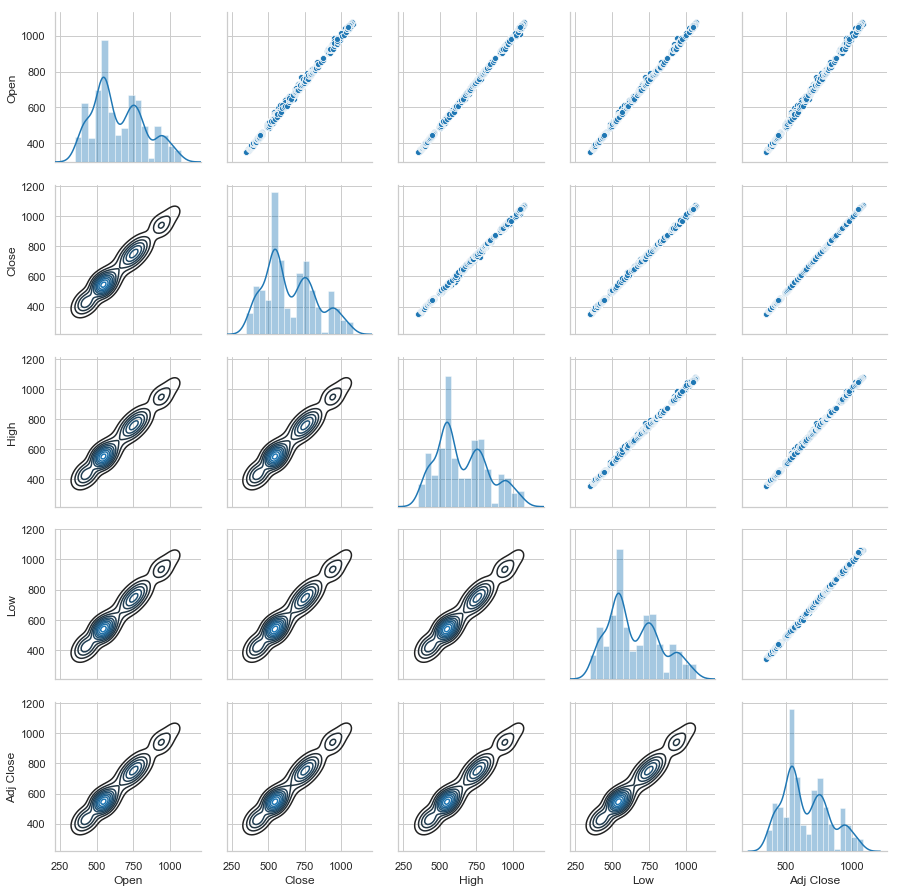

In [0]:
grid = sns.PairGrid(train_set[['Open','Close','High','Low','Adj Close']])
grid. map_diag(sns.distplot)
grid.map_upper(sns.scatterplot)
grid.map_lower(sns.kdeplot)

All `open`,`high`,`low`, `close` and `adjusted close` price values have same distribution and they are highly correlated with each other (almost equal I would say). This is expected since the all the time series price points recorded within a day act in a similar fashion, i.e., we cannot expect to observe huge variations over these 5 mearurements in a single day.

Below plot further ensure above statement.

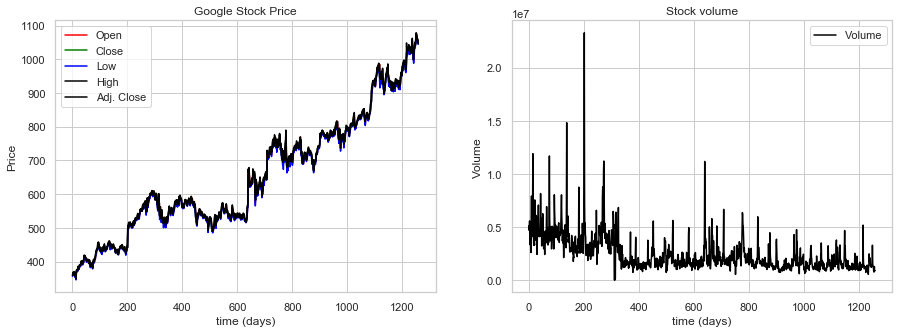

In [0]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(train_set['Open'].values, color='red', label='Open')
plt.plot(train_set['Close'].values, color='green', label='Close')
plt.plot(train_set['Low'].values, color='blue', label='Low')
plt.plot(train_set['High'].values, color='black', label='High')
plt.plot(train_set['Adj Close'].values, color='black', label='Adj. Close')
plt.title('Google Stock Price')
plt.xlabel('time (days)')
plt.ylabel('Price')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(train_set['Volume'].values, color='black', label='Volume')
plt.title('Stock volume')
plt.xlabel('time (days)')
plt.ylabel('Volume')
plt.legend(loc='best');

Since all 5 price variables act in a similar way, for modelling and forecasting purposes, it is sufficient to only focus on a single variable, therefore I will be using the `Adjusted Close` values moving forward.

This is due to the fact that, `Adjusted Close` gives us an accurate representation of the equity value beyond the simple market price as tt accounts for all corporate actions such as stock splits, dividends/distributions and rights offerings. (Source: [Investopedia: Adjusted Closing Price](https://www.investopedia.com/terms/a/adjusted_closing_price.asp) )

## Data Pre-processing

Data preprocessing steps mainly include setting up the **reduced dataset** having only the interested variables as well as normalizing the stock price data.

First I create a subset only with `Date` and `Adjusted Price` variables to be used for the next analysis steps.

In [248]:
#reduced training dataset
train_set_reduced = train_set.copy()
train_set_reduced.drop(['Open','Close','High','Low','Volume'],axis=1,inplace=True)
train_set_reduced['Date'] = pd.to_datetime(train_set_reduced['Date'])
train_set_reduced.head()

,Date,Adj Close
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


For the reduced dataset, now I convert its indexes to have *Date-Time* values since it'll make the futher analysis steps easier. *(Note that I am also dropping out the `Volume` variable with the assumption that *volume* traded within a day has no impact on deciding the a days' price)*

In [249]:
#reindex with data-time
train_set_reduced = train_set_reduced.set_index('Date')
train_set_reduced.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [0]:
train_set_reduced.head(10)

,Adj Close
Date,
2013-01-02,359.288177
2013-01-03,359.496826
2013-01-04,366.600616
2013-01-07,365.001007
2013-01-08,364.280701
2013-01-09,366.675140
2013-01-10,368.344269
2013-01-11,367.604095
2013-01-14,359.288177


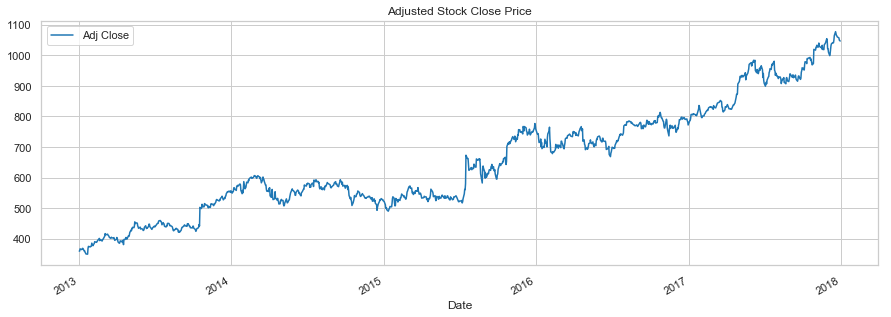

In [0]:
train_set_reduced.plot(figsize = (15,5), title="Adjusted Stock Close Price")

As we know time series data is consists of *trend*, *seasonality* and *error* components.

The `seasonal_decompose` method in `statsmodels` package allows us to visualize these distinct components separately in python.

*Note that after observing the line plot of price data, it's evident that there exists an upward trend. There also seems to contain seasonality, but the amplitude (height) does not seem to be increasing (thus not 'multiplicative'). Due to this reason, I have considered the *additive* model which captures *monthly* seasonality for the decomposition.*

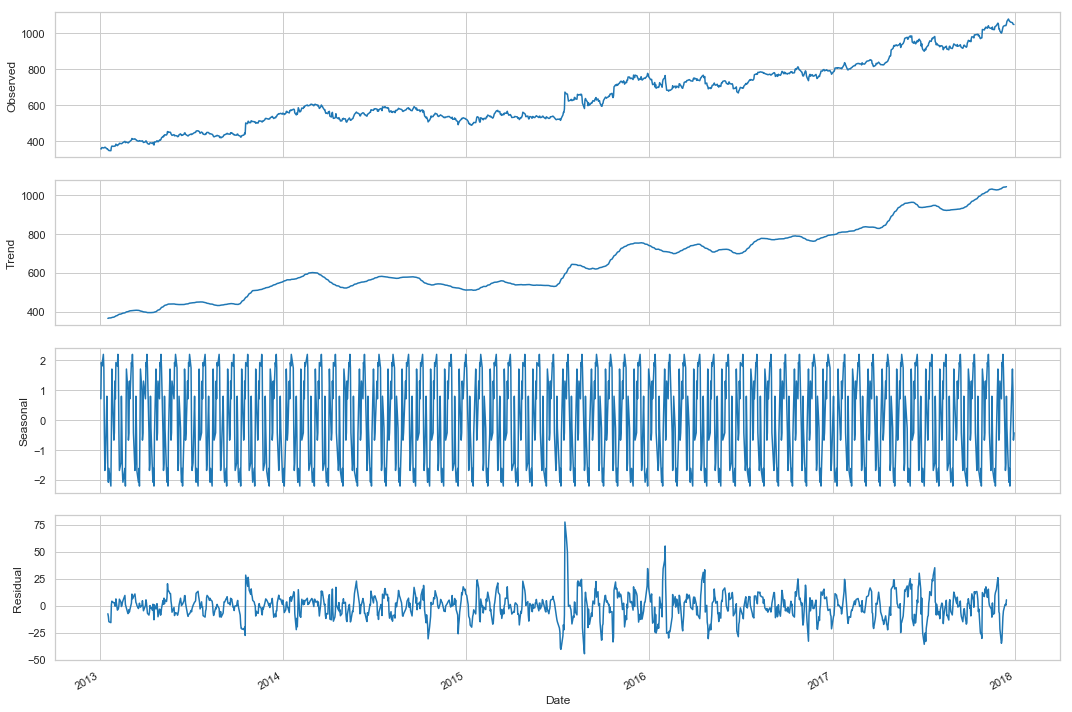

In [0]:
rcParams['figure.figsize'] = 15, 10

decomp = stm.tsa.seasonal_decompose(train_set_reduced['Adj Close'], freq = 20, model='additive')

fig = decomp.plot()

## Deciding a Model

One of the most commonly used methods for time-series forcasting is **ARIMA**, which stands for **Autoregressive Integrated Moving Average**.

ARIMA models are denoted with the notation ARIMA(p, d, q).

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

After analyzing the price data, it's obvious that we have a time series with a **seasonal component**. So it make sense to use a **Seasonal ARIMA** model. 

In order to do this we will need to choose *p,d,q* values for the *ARIMA*, and *P,D,Q* values for the *Seasonal component*.

As you'd understand, the capabilities of a fitted SARIMA model would fully depend on the selection of above parameters. Even though there are different ways to choose the values such as looking at *auto-correlation plots* and *correlation plots* I will be using an intelligent grid search methodology provided by `pmdarima` package to find optimal p,d,q,P,D,and Q values based on minimum the *Akaike information criterion (AIC)*.


In [0]:
mod_1 = auto_arima(train_set_reduced, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=20,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(mod_1.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 20); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 20); AIC=9678.398, BIC=9688.640, Fit time=0.263 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 20); AIC=9366.047, BIC=9386.532, Fit time=7.045 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 20); AIC=8970.229, BIC=8990.714, Fit time=26.350 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 20); AIC=8968.428, BIC=8994.034, Fit time=35.512 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 20); AIC=9366.048, BIC=9386.533, Fit time=8.902 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 20); AIC=8970.223, BIC=9000.951, Fit time=106.775 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 20); AIC=9680.392, BIC=9695.756, Fit time=1.694 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 20); AIC=8972.167, BIC=9008.016, Fit time=42.615 seconds
Fit ARIMA: order=(1, 1, 1) seasonal

The resulting best model parameters results with an AIC value of 8967.33.

Now I fit this model on the training dataset

In [0]:
mod_fit = mod_1.fit(train_set_reduced)

print(mod_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1259
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 20)   Log Likelihood               -4479.663
Date:                            Sun, 17 Feb 2019   AIC                           8967.326
Time:                                    14:37:27   BIC                           8987.811
Sample:                                         0   HQIC                          8975.030
                                           - 1259                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0072      0.013      0.555      0.579      -0.018       0.032
ar.S.L20       0.0575      0.027   

In order to confirm the goodness-of-fit of the the fitted model, I run below steps to investigate any unsual behaviors.

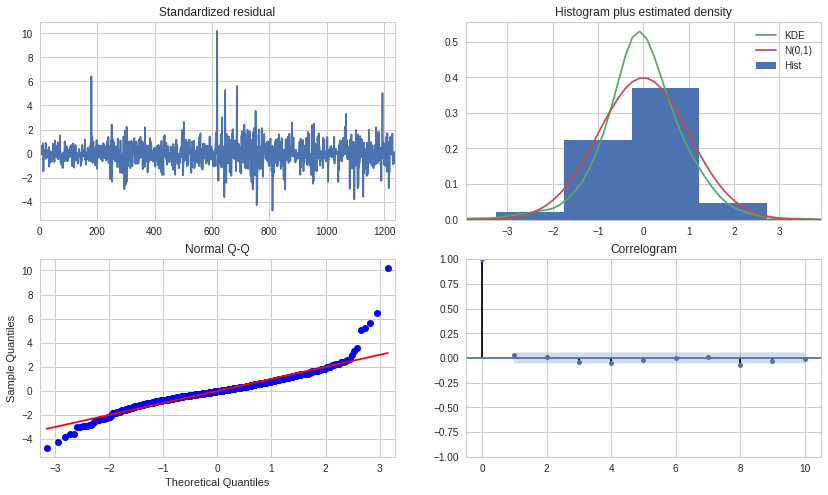

In [260]:
rcParams['figure.figsize'] = 14, 8

mod_fit.plot_diagnostics()
plt.show()

Above residual errors seems to be random and approximately normally distributed, thus we can be think that there is no any underlying trend that hasn't been captured by the model.

Additionally, the distribution of the residual errors also shows that there does not appear to be any bias in the prediction (residual mean is almost equal to zero).

## Model Validation—Forecast on Test Data

Now I have built a reasonable model, but to ensure it's forecasting capabilities, I try to predict the price data for the **Test Dataset**.

In [0]:
#preprocess test dataset
test_set_reduced = test_set.copy()
test_set_reduced.drop(['Open','Close','High','Low','Volume'],axis=1,inplace=True)
test_set_reduced['Date'] = pd.to_datetime(test_set_reduced['Date'])
test_set_reduced = test_set_reduced.set_index('Date')
test_set_reduced.head()

,Adj Close
Date,
2018-01-02,1065.000000
2018-01-03,1082.479980
2018-01-04,1086.400024
2018-01-05,1102.229980
2018-01-08,1106.939941


In [0]:
forecast = mod_1.predict(n_periods=126, return_conf_int=True)
forecast_vals = forecast[0]
forecast_ci = forecast[1]


In [0]:
forecast_vals_df = pd.DataFrame(forecast_vals[1:126], index = test_set_reduced.index, columns=['Prediction'])
forecast_ci_df = pd.DataFrame(forecast_ci[1:126],columns =['Lower','Upper'], index = test_set_reduced.index)

In [0]:
test_set_reduced.head()

,Adj Close
Date,
2018-01-02,1065.000000
2018-01-03,1082.479980
2018-01-04,1086.400024
2018-01-05,1102.229980
2018-01-08,1106.939941


In [0]:
test_and_predicted_reduced = pd.concat([test_set_reduced,forecast_vals_df,forecast_ci_df],axis=1)
test_and_predicted_reduced.head()

,Adj Close,Prediction,Lower,Upper
Date,,,,
2018-01-02,1065.000000,1047.661531,1023.264491,1072.058571
2018-01-03,1082.479980,1049.932905,1020.054006,1079.811805
2018-01-04,1086.400024,1051.469242,1016.968783,1085.969702
2018-01-05,1102.229980,1053.306551,1014.734348,1091.878753
2018-01-08,1106.939941,1053.984838,1011.731461,1096.238215


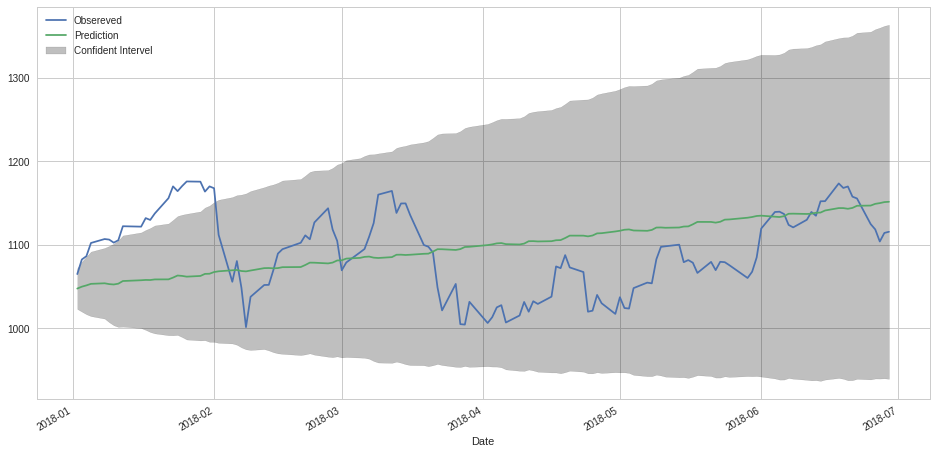

In [261]:
ax =  test_and_predicted_reduced['Adj Close'].plot(figsize = (16,8), label = 'Obsereved')
ax =  test_and_predicted_reduced['Prediction'].plot()
ax.fill_between(test_and_predicted_reduced.index,
                test_and_predicted_reduced['Lower'], 
                test_and_predicted_reduced['Upper'],
                label = 'Confident Intervel', color='k', alpha=.25)
ax.legend(loc = 2)

As it is seen, our model does an extremely poor job in capturing the seasonality and it only successfully predicts the trend. Correct parametrization of SARIMA models could seems to be a complicated manual process and it tends to require a lot of time.

Therefore, I am going to deviate from the traditional models and try to test a new method/package published by Facebook to model this data .

## Forecasts using Facebook’s Prophet

It was clear that the SARIMA model did not work as intended because the set of parameters we used did not reflect the trend and especially the seasonality in our data.

The `Prophet` package developed by Facebook provides intuitive parameters which are easy to tune even when we do not have enough prior knowledge about the data. Working with this package is easy for even someone who lacks expertise in forecasting models. [reference](https://facebook.github.io/prophet/)

Before working with `Prophet`, we need to process the data as it requires the variable names in the time series to be as follows:

* y – Target
* ds – Datetime

In [0]:
train_set_reduced_prop = train_set_reduced.copy()

train_set_reduced_prop['ds'] = train_set_reduced_prop.index
train_set_reduced_prop['y'] = train_set_reduced_prop['Adj Close'].values
train_set_reduced_prop.drop(['Adj Close'],axis = 1, inplace = True)
train_set_reduced_prop.head()

,ds,y
Date,,
2013-01-02,2013-01-02,359.288177
2013-01-03,2013-01-03,359.496826
2013-01-04,2013-01-04,366.600616
2013-01-07,2013-01-07,365.001007
2013-01-08,2013-01-08,364.280701


First I initialize the `Prophet` model:

In [0]:
mod_2 = Prophet(daily_seasonality=True,
                weekly_seasonality = 10,
                yearly_seasonality = 20,
                changepoint_prior_scale = 0.07,
                seasonality_prior_scale=0.15,
                interval_width = 0.85)

After initialization, I call its fit method with our dataframe as input

In [0]:
mod_2.fit(train_set_reduced_prop)

To obtain forecasts of our time series, `Prophet` needs a new DataFrame containing a ds column that holds the dates that we want to predict.

This is automatically handled by Prophet's `make_future_dataframe` helper function:

In [0]:
future = mod_2.make_future_dataframe(periods=200)


The dataframe of future dates is then used as input to the predict method of our fitted model.

In [0]:
forecast_prop = mod_2.predict(future)

In [0]:
forecast_prop[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1454,2018-07-13,1187.698223,1086.885689,1297.949923
1455,2018-07-14,1191.244066,1089.841044,1304.982866
1456,2018-07-15,1196.070776,1097.429717,1308.254741
1457,2018-07-16,1201.410675,1095.292586,1312.169014
1458,2018-07-17,1205.873966,1102.207625,1321.802678


We can access various components of the forecast using the following command. 

This can be used to understand how how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

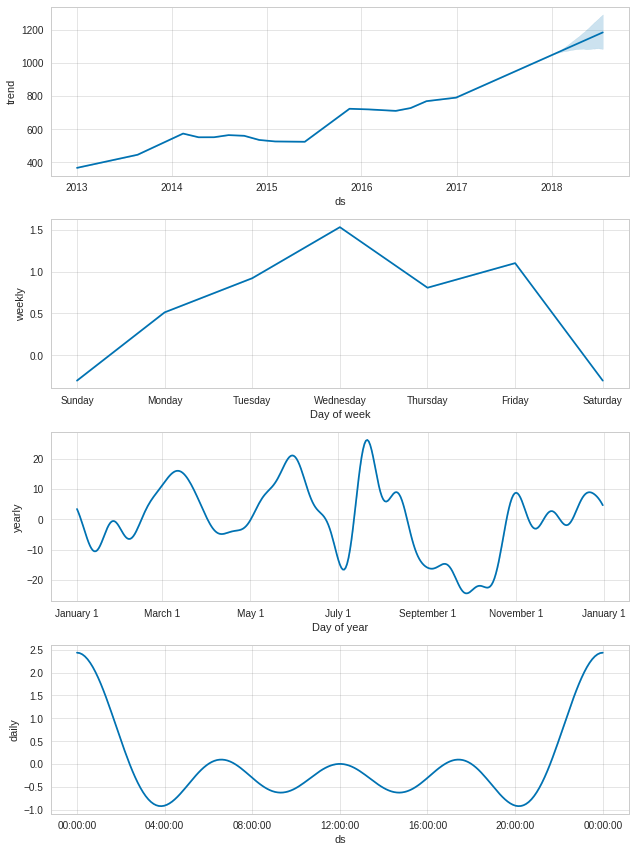

In [254]:
mod_2.plot_components(forecast_prop)
plt.show()


As you can see, this new technique seems to capture a lot of data which was not included in the traditional SARIMA model that we constructed before.

This package also provides an easy way to quickly plot the results of our forecasts:

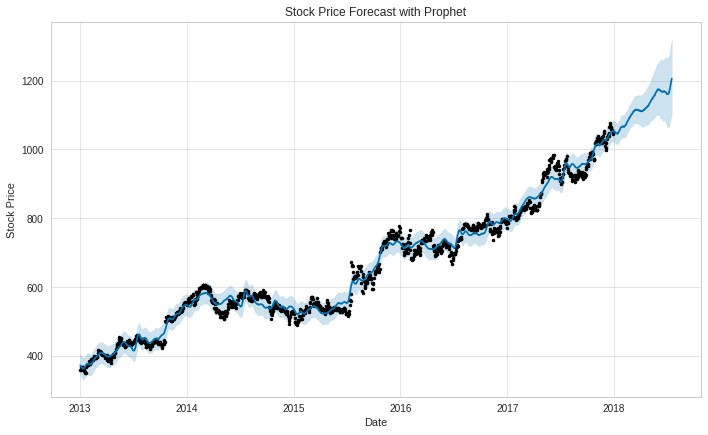

In [264]:
mod_2.plot(forecast_prop, xlabel = 'Date', ylabel = 'Stock Price')
plt.title('Stock Price Forecast with Prophet');

Since we already have **test data**, now I will check how the model predictions are matching againt the real observed values.

In [0]:
#preprocess the forecast dataset
forecast_prop_reduced = forecast_prop.copy()
forecast_prop_reduced = forecast_prop_reduced[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_prop_reduced['ds'] = pd.to_datetime(forecast_prop_reduced['ds'])
forecast_prop_reduced.index = forecast_prop_reduced['ds']
forecast_prop_reduced.drop('ds', inplace=True, axis = 1)
forecast_prop_reduced.tail()


,yhat,yhat_lower,yhat_upper
ds,,,
2018-07-13,1187.698223,1086.885689,1297.949923
2018-07-14,1191.244066,1089.841044,1304.982866
2018-07-15,1196.070776,1097.429717,1308.254741
2018-07-16,1201.410675,1095.292586,1312.169014
2018-07-17,1205.873966,1102.207625,1321.802678


In [0]:
#join forecast dataset with test dataset

forecast_prop_test = pd.concat([test_set_reduced, forecast_prop_reduced], axis=1, join='inner')


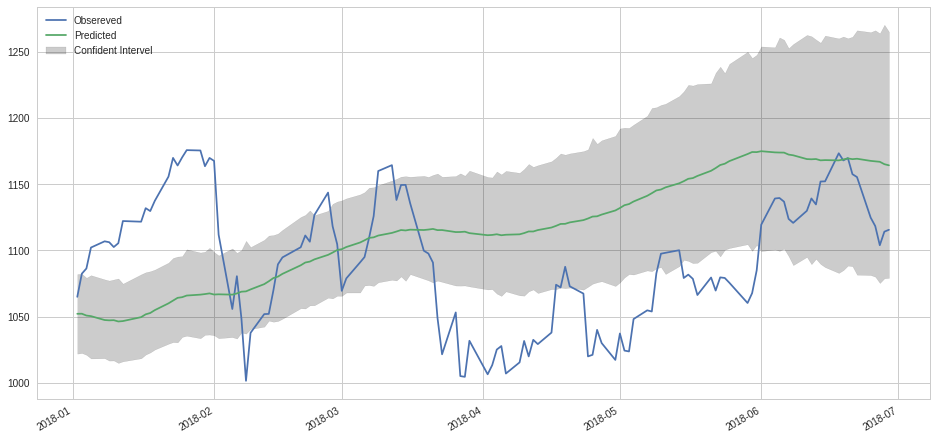

In [265]:
ax2 =  forecast_prop_test['Adj Close'].plot(figsize = (16,8), label = 'Obsereved')
ax2 =  forecast_prop_test['yhat'].plot(label = 'Predicted')
ax2.fill_between(forecast_prop_test.index,
                forecast_prop_test['yhat_lower'], 
                forecast_prop_test['yhat_upper'],
                label = 'Confident Intervel', color='k', alpha=.2)
ax2.legend(loc = 2)

Observing the above plot and comparing it with the results that we obtained by SARIMA model, it's clear that `Prophet` does a better job in identifying the trend and seasonal variation in the stock price data.

Even so, there is still a significant error which is not captured as we can see, there are observed values speading even beyond the confidence bands.





### Future Work:

There is a significant amount of research work published on applying **LSTM** Recurrent Neural Networks to model time series data. Therefore, as the next step, I feel it would be a good approach to try out.